In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import ast

In [3]:
credits_df = pd.read_csv('tmdb_5000_credits.csv')

In [4]:
movies_df = pd.read_csv('tmdb_5000_movies.csv')

Now, we will combine both of our dataset. For that we have two columns from which we can combine,one is "id" and the other is "title".
Lets combine it based on the "title" column.

In [6]:
df = movies_df.merge(credits_df,on='title')

In [7]:
df.shape

(4809, 25)

In [8]:
df=df.drop(['budget','original_title','homepage','id','original_language','production_companies','production_countries',
           'release_date','revenue','runtime','spoken_languages','status','tagline'],axis=1)

In [9]:
df.head(3)

,Unnamed: 0,user_id,genres,keywords,overview,popularity,title,vote_average,vote_count,movie_id,cast,crew
0,0,1631,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","In the 22nd century, a paraplegic Marine is di...",150.437577,Avatar,7.2,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,1,1605,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","Captain Barbossa, long believed to be dead, ha...",139.082615,Pirates of the Caribbean: At World's End,6.9,4500,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,2,1575,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",A cryptic message from Bond’s past sends him o...,107.376788,Spectre,6.3,4466,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    4809 non-null   int64  
 1   user_id       4809 non-null   int64  
 2   genres        4809 non-null   object 
 3   keywords      4809 non-null   object 
 4   overview      4806 non-null   object 
 5   popularity    4809 non-null   float64
 6   title         4809 non-null   object 
 7   vote_average  4809 non-null   float64
 8   vote_count    4809 non-null   int64  
 9   movie_id      4809 non-null   int64  
 10  cast          4809 non-null   object 
 11  crew          4809 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 451.0+ KB


In [11]:
df.isnull().sum()

Unnamed: 0      0
user_id         0
genres          0
keywords        0
overview        3
popularity      0
title           0
vote_average    0
vote_count      0
movie_id        0
cast            0
crew            0
dtype: int64

## Content Based Recommendation System

Content based recommendation system suggest similar items based on a particular item. They uses values such as genre, director, description, actors, etc. in case of movies to makerecommendations. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.

#### For our content based recommendation system, we will use two approaches. First, we will make recommendations based on the overview of the movies as this contains detailed information about the movies, secondly, we will make recommendations based on the genre, actors and directors since they also helps in finding the similar movies

#### Now, we will use only those columns wich will be of value to our content based recommendation system

In [15]:
content_df = df.copy()

In [16]:
content_df = content_df[['movie_id','title','overview','genres','keywords','cast','crew']]

In [17]:
content_df.head(2)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


#### Now, lets look at the "genres" table

In [19]:
content_df['genres'][0]

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

#### Since it is a string, we have to convert it into an actual list of dictionaries

In [21]:
ast.literal_eval(content_df['genres'][0])

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

#### Now, lets do it on the whole column

In [23]:
def dict_convert(string):
       return [string for string in ast.literal_eval(string)]

In [24]:
content_df['genres']= content_df['genres'].apply(dict_convert)

In [25]:
content_df['genres'][0]

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

#### Now we can extract name from the dictionaries

In [27]:
def genre_name(col):
    name_list = []
    for i in col:
        name_list.append(i['name'])
    return name_list

In [28]:
content_df['genres']= content_df['genres'].apply(genre_name)

In [29]:
content_df['cast'][0]

'[{"cast_id": 242, "character": "Jake Sully", "credit_id": "5602a8a7c3a3685532001c9a", "gender": 2, "id": 65731, "name": "Sam Worthington", "order": 0}, {"cast_id": 3, "character": "Neytiri", "credit_id": "52fe48009251416c750ac9cb", "gender": 1, "id": 8691, "name": "Zoe Saldana", "order": 1}, {"cast_id": 25, "character": "Dr. Grace Augustine", "credit_id": "52fe48009251416c750aca39", "gender": 1, "id": 10205, "name": "Sigourney Weaver", "order": 2}, {"cast_id": 4, "character": "Col. Quaritch", "credit_id": "52fe48009251416c750ac9cf", "gender": 2, "id": 32747, "name": "Stephen Lang", "order": 3}, {"cast_id": 5, "character": "Trudy Chacon", "credit_id": "52fe48009251416c750ac9d3", "gender": 1, "id": 17647, "name": "Michelle Rodriguez", "order": 4}, {"cast_id": 8, "character": "Selfridge", "credit_id": "52fe48009251416c750ac9e1", "gender": 2, "id": 1771, "name": "Giovanni Ribisi", "order": 5}, {"cast_id": 7, "character": "Norm Spellman", "credit_id": "52fe48009251416c750ac9dd", "gender": 

In [30]:
content_df['cast']=content_df['cast'].apply(dict_convert)

#### Extracting all the names would make it pretty big, so will extract four name from the dictionaries

In [32]:
def cast_name(col):
    cast_list = []
    counter = 0
    for i in col:
        if counter < 3:
            cast_list.append(i['name'])
        counter+=1
    return cast_list

In [33]:
content_df['cast']=content_df['cast'].apply(cast_name)

In [34]:
content_df['cast']

0        [Sam Worthington, Zoe Saldana, Sigourney Weaver]
1           [Johnny Depp, Orlando Bloom, Keira Knightley]
2            [Daniel Craig, Christoph Waltz, Léa Seydoux]
3            [Christian Bale, Michael Caine, Gary Oldman]
4          [Taylor Kitsch, Lynn Collins, Samantha Morton]
                              ...                        
4804    [Carlos Gallardo, Jaime de Hoyos, Peter Marqua...
4805         [Edward Burns, Kerry Bishé, Marsha Dietlein]
4806           [Eric Mabius, Kristin Booth, Crystal Lowe]
4807            [Daniel Henney, Eliza Coupe, Bill Paxton]
4808    [Drew Barrymore, Brian Herzlinger, Corey Feldman]
Name: cast, Length: 4809, dtype: object

In [35]:
content_df['crew'][0]

'[{"credit_id": "52fe48009251416c750aca23", "department": "Editing", "gender": 0, "id": 1721, "job": "Editor", "name": "Stephen E. Rivkin"}, {"credit_id": "539c47ecc3a36810e3001f87", "department": "Art", "gender": 2, "id": 496, "job": "Production Design", "name": "Rick Carter"}, {"credit_id": "54491c89c3a3680fb4001cf7", "department": "Sound", "gender": 0, "id": 900, "job": "Sound Designer", "name": "Christopher Boyes"}, {"credit_id": "54491cb70e0a267480001bd0", "department": "Sound", "gender": 0, "id": 900, "job": "Supervising Sound Editor", "name": "Christopher Boyes"}, {"credit_id": "539c4a4cc3a36810c9002101", "department": "Production", "gender": 1, "id": 1262, "job": "Casting", "name": "Mali Finn"}, {"credit_id": "5544ee3b925141499f0008fc", "department": "Sound", "gender": 2, "id": 1729, "job": "Original Music Composer", "name": "James Horner"}, {"credit_id": "52fe48009251416c750ac9c3", "department": "Directing", "gender": 2, "id": 2710, "job": "Director", "name": "James Cameron"},

#### We can extract the names of directors from the crew column

In [37]:
content_df['crew']=content_df['crew'].apply(dict_convert)

In [38]:
def get_director(obj):
    list_dir = []
    for i in obj:
        if i['job'] == 'Director':
            list_dir.append(i['name'])
    return list_dir

In [39]:
content_df['director']=content_df['crew'].apply(get_director)

In [40]:
content_df['director'].isnull().sum()

0

In [41]:
content_df['director']

0                                [James Cameron]
1                               [Gore Verbinski]
2                                   [Sam Mendes]
3                            [Christopher Nolan]
4                               [Andrew Stanton]
                          ...                   
4804                          [Robert Rodriguez]
4805                              [Edward Burns]
4806                               [Scott Smith]
4807                               [Daniel Hsia]
4808    [Brian Herzlinger, Jon Gunn, Brett Winn]
Name: director, Length: 4809, dtype: object

In [42]:
content_df = content_df.drop('crew',axis=1)

In [43]:
content_df['keywords']=content_df['keywords'].apply(dict_convert)

In [44]:
content_df['keywords'][0]

[{'id': 1463, 'name': 'culture clash'},
 {'id': 2964, 'name': 'future'},
 {'id': 3386, 'name': 'space war'},
 {'id': 3388, 'name': 'space colony'},
 {'id': 3679, 'name': 'society'},
 {'id': 3801, 'name': 'space travel'},
 {'id': 9685, 'name': 'futuristic'},
 {'id': 9840, 'name': 'romance'},
 {'id': 9882, 'name': 'space'},
 {'id': 9951, 'name': 'alien'},
 {'id': 10148, 'name': 'tribe'},
 {'id': 10158, 'name': 'alien planet'},
 {'id': 10987, 'name': 'cgi'},
 {'id': 11399, 'name': 'marine'},
 {'id': 13065, 'name': 'soldier'},
 {'id': 14643, 'name': 'battle'},
 {'id': 14720, 'name': 'love affair'},
 {'id': 165431, 'name': 'anti war'},
 {'id': 193554, 'name': 'power relations'},
 {'id': 206690, 'name': 'mind and soul'},
 {'id': 209714, 'name': '3d'}]

In [45]:
def keywords_name(col):
    keywords_list = []
    for i in col:
        keywords_list.append(i['name'])
    return keywords_list

In [46]:
content_df['keywords']=content_df['keywords'].apply(keywords_name)

In [47]:
content_df.head()

,movie_id,title,overview,genres,keywords,cast,director
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron]
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski]
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Daniel Craig, Christoph Waltz, Léa Seydoux]",[Sam Mendes]
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,"[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...","[Christian Bale, Michael Caine, Gary Oldman]",[Christopher Nolan]
4,49529,John Carter,"John Carter is a war-weary, former military ca...","[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...","[Taylor Kitsch, Lynn Collins, Samantha Morton]",[Andrew Stanton]


Now, if we can see in our dataset the values are in the cast, director, genres and keywords column are repeating for eg, 'Sam Worthington' and 'Sam Mendes' and it will create problems in recognizing similar movies, so we will make them a single word for eg, 'SamMendes' and 'SamWorthington' and will also convert them to lower case

In [49]:
def combine(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [50]:
content_df['cast'] = content_df['cast'].apply(combine)
content_df['director'] = content_df['director'].apply(combine)
content_df['genres'] = content_df['genres'].apply(combine)
content_df['keywords'] = content_df['keywords'].apply(combine)

In [51]:
content_df.head()

,movie_id,title,overview,genres,keywords,cast,director
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[action, adventure, fantasy, sciencefiction]","[cultureclash, future, spacewar, spacecolony, ...","[samworthington, zoesaldana, sigourneyweaver]",[jamescameron]
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[adventure, fantasy, action]","[ocean, drugabuse, exoticisland, eastindiatrad...","[johnnydepp, orlandobloom, keiraknightley]",[goreverbinski]
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[action, adventure, crime]","[spy, basedonnovel, secretagent, sequel, mi6, ...","[danielcraig, christophwaltz, léaseydoux]",[sammendes]
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,"[action, crime, drama, thriller]","[dccomics, crimefighter, terrorist, secretiden...","[christianbale, michaelcaine, garyoldman]",[christophernolan]
4,49529,John Carter,"John Carter is a war-weary, former military ca...","[action, adventure, sciencefiction]","[basedonnovel, mars, medallion, spacetravel, p...","[taylorkitsch, lynncollins, samanthamorton]",[andrewstanton]


#### Now, this looks good

In [53]:
content_df.title.value_counts()

title
The Host                 4
Batman                   4
Out of the Blue          4
Avatar                   1
The Girl on the Train    1
                        ..
Step Up 3D               1
Secondhand Lions         1
The Age of Adaline       1
Drag Me to Hell          1
My Date with Drew        1
Name: count, Length: 4800, dtype: int64

### Handling Null Values

In [55]:
content_df.isnull().sum()

movie_id    0
title       0
overview    3
genres      0
keywords    0
cast        0
director    0
dtype: int64

In [56]:
content_df['overview'] = content_df['overview'].fillna('')

### Overview Based Recommender

#### Now we'll compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each overview.

TF-IDF it is the relative frequency of a word in a document and is given as **(term instances/total instances)**. Inverse Document Frequency is the relative count of documents containing the term is given as **log(number of documents / documents with term)**. The overall importance of each word to the documents in which they appear is equal to **TF * IDF**.

This will give a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document) and each row represents a movie, as before.This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.

In [59]:
tfidf=TfidfVectorizer(stop_words='english',
                                ngram_range=(1, 1),)

In [60]:
tfidf_vector = tfidf.fit_transform(content_df['overview'])

In [61]:
tfidf_vector.shape

(4809, 20978)

We see that over 20,000 different words were used to describe the 4800 movies in our dataset.

With this matrix in hand, we can now compute a similarity score. There are several candidates for this; such as the euclidean, sigmoid_kernel and the cosine similarity scores. There is no right answer to which score is the best. Different scores work well in different scenarios and it is often a good idea to experiment with different metrics.

In our case, we will use two metrics, cosine similarity and sigmoid kernel

### Cosine Similarity


Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's **linear_kernel()** instead of cosine_similarities() since it is faster.



In [64]:
# Compute the cosine similarity matrix
cos_sim = linear_kernel(tfidf_vector, tfidf_vector)
indices= pd.Series(df.index, index=content_df['title']).drop_duplicates()

In [65]:
def recommender_1(title, kernel=cos_sim):
    # Get the index corresponding to original_title
    idx = indices[title]
    # Get the pairwsie similarity scores 
    kernel_scores = list(enumerate(kernel[idx]))
    # Sort the movies 
    kernel_scores = sorted(kernel_scores, key=lambda x: x[1], reverse=True)
    # Scores of the 10 most similar movies
    kernel_scores = kernel_scores[1:11]
    # Movie indices
    movie_indices = [i[0] for i in kernel_scores]
    # Top 10 most similar movies
    return df['title'].iloc[movie_indices]

#### Now, lets do recommendation based on our algorithm

In [67]:
recommender_1('Thor')

126                   Thor: The Dark World
3539                              Galaxina
14                            Man of Steel
2702                               Jason X
220                             Prometheus
1477                                 Ponyo
1047    Journey to the Center of the Earth
420            Hellboy II: The Golden Army
2239                            Little Boy
476                             Surrogates
Name: title, dtype: object

### Credits, Genres and Keywords Based Recommender

We are going to build a recommender based on the following data: the 3 top actors, the director, related genres and the movie plot keywords.

First, we will combine the 'genres','keywords','cast' and 'director' columns to a single column 'tag' and then convert it into required matrix

In [70]:
def create_tag(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + ' '.join(x['director']) + ' ' + ' '.join(x['genres'])

In [71]:
content_df['tag'] = content_df.apply(create_tag, axis=1)

In [72]:
content_df.tag[0]

'cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsoul 3d samworthington zoesaldana sigourneyweaver jamescameron action adventure fantasy sciencefiction'

In [73]:
count = CountVectorizer(lowercase=True,stop_words='english')

In [74]:
count_matrix = count.fit_transform(content_df['tag'])

In [75]:
count_matrix.shape

(4809, 18053)

Since here we have not used TF-IDF, so we will use cosine similarity instead of linear kernal.

In [77]:
cos_sim2 = cosine_similarity(count_matrix, count_matrix)

In [78]:
indices2= pd.Series(df.index, index=content_df['title']).drop_duplicates()

In [79]:
def recommender_2(title, kernel=cos_sim2):

    # Get the index corresponding to original_title
    idx = indices2[title]

    # Get the pairwsie similarity scores 
    kernel_scores = list(enumerate(kernel[idx]))

    # Sort the movies 
    kernel_scores = sorted(kernel_scores, key=lambda x: x[1], reverse=True)

    # Scores of the 10 most similar movies
    kernel_scores = kernel_scores[1:11]

    # Movie indices
    movie_indices = [i[0] for i in kernel_scores]

    # Top 10 most similar movies
    return df['title'].iloc[movie_indices]

In [80]:
recommender_2('Thor')

126                   Thor: The Dark World
182                                Ant-Man
7                  Avengers: Age of Ultron
85     Captain America: The Winter Soldier
16                            The Avengers
79                              Iron Man 2
26              Captain America: Civil War
169     Captain America: The First Avenger
31                              Iron Man 3
68                                Iron Man
Name: title, dtype: object

## Recommendation System Using Collaborative Filtering

#### Now we will make our recommendations based on the collaborative filtering. This filtering method is usually based on collecting and analyzing information on user’s behaviors, their activities or preferences, and predicting what they will like based on the similarity with other users.

In [83]:
df.head(3)

,Unnamed: 0,user_id,genres,keywords,overview,popularity,title,vote_average,vote_count,movie_id,cast,crew
0,0,1631,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","In the 22nd century, a paraplegic Marine is di...",150.437577,Avatar,7.2,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,1,1605,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","Captain Barbossa, long believed to be dead, ha...",139.082615,Pirates of the Caribbean: At World's End,6.9,4500,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,2,1575,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",A cryptic message from Bond’s past sends him o...,107.376788,Spectre,6.3,4466,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


In [189]:
df_col = df.copy()

#### Now, we will use only those columns wich will be of value to our collaborative based recommendation system

In [192]:
df_col = df_col[['user_id','movie_id','title','vote_average',]]

<Axes: xlabel='vote_average'>

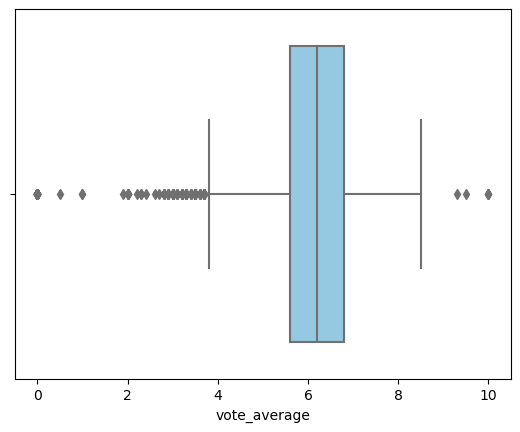

In [194]:
# Define a color-blind-friendly palette
color_blind_palette = ["#88CCEE", "#DDCC77", "#CC6677", "#117733", "#332288"]

sns.boxplot(x='vote_average',data=df_col, color=color_blind_palette[0])

In [196]:
outlier = df_col['vote_average'].quantile(0.05)
df_col = df_col[df_col['vote_average']>outlier]

<Axes: xlabel='vote_average'>

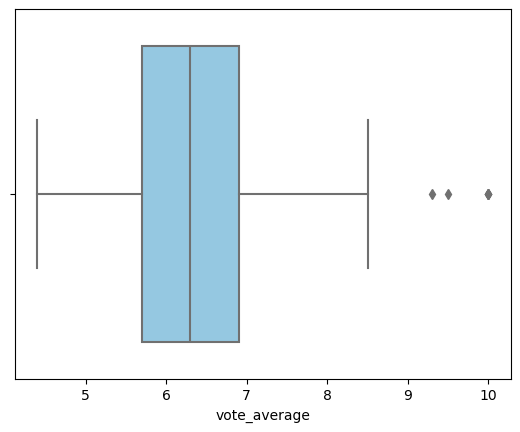

In [198]:
sns.boxplot(x='vote_average',data=df_col, color=color_blind_palette[0])

In [90]:
df_col_pivot=df_col.pivot_table(index='title',columns='user_id',values='vote_average').fillna(0)

Now, we convert this pivot table into a sparse matrix.A sparse matrix basically idicates that most of the values will be zeros and some the values will be non zeros that were actually the votings here

In [92]:
df_col_matrix = csr_matrix(df_col_pivot.values)

#### Now, we will use nearest neighbor algorithm to find the most similar movies. Nearest neighbor method basically finds a predefined number of samples closest in distance to a particular point

In [94]:

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute',n_neighbors=5)
model_knn.fit(df_col_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

#### Now, lets do recommendation based on our algorithm

In [96]:
def recommender_3(name):
    print(name)
    distances3, indices3 = model_knn.kneighbors(df_col_pivot.loc[name,:].values.reshape(1, -1), n_neighbors = 6)
    for i in range(0, len(distances3.flatten())):
        print('{0}: {1}'.format(i, df_col_pivot.index[indices3.flatten()[i]]))

In [97]:
recommender_3('Thor')

Thor
0: Creed
1: Riddick
2: Iguana
3: Top Hat
4: Tomorrowland
5: The Adventures of Tintin


## Evaluation 

Now, that we have recommendation system. Let's evaluate the performance of our recommendation system

In [99]:
distances3, indices3 = model_knn.kneighbors(df_col_pivot.values)

In [100]:
itm_dist = 1-distances3

In [101]:
pred = itm_dist.T.dot(df_col_pivot.values)/np.array([np.abs(itm_dist.T).sum(axis=1)]).T

In [102]:
true_val = df_col_pivot.values[itm_dist.argsort()[0]]

In [103]:
def rmse(pred,true_val):
    pred = pred[true_val.nonzero()].flatten()
    true_val = true_val[true_val.nonzero()].flatten()
    return sqrt(mean_squared_error(pred,true_val))

In [104]:
error_rate = rmse(pred,true_val)
print('Accuracy: {:0.3f}'.format(100 - error_rate))
print('RMSE: {:0.5f}'.format(error_rate))

Accuracy: 93.478
RMSE: 6.52200
